# <span style="color:#0b486b">  FIT5215: Deep Learning (2024)</span>
***
*CE/Lecturer (Clayton):*  **Dr Trung Le** | trunglm@monash.edu <br/>
*Lecturer (Clayton):* **Prof Dinh Phung** | dinh.phung@monash.edu <br/>
*Lecturer (Malaysia):*  **Dr Arghya Pal** | arghya.pal@monash.edu <br/>
*Lecturer (Malaysia):*  **Dr Lim Chern Hong** | lim.chernhong@monash.edu <br/>  <br/>
*Head Tutor 3181:*  **Miss Vy Vo** |  \[v.vo@monash.edu \] <br/>
*Head Tutor 5215:*  **Dr Van Nguyen** |  \[van.nguyen1@monash.edu \]

<br/> <br/>
Faculty of Information Technology, Monash University, Australia
***

# <span style="color:#0b486b">  Student Information</span>
***
Surname: **Peng**  <br/>
Firstname: **Yuhang**    <br/>
Student ID: **34278818**    <br/>
Email: **ypen0076@student.monash.edu**    <br/>
Your tutorial time: **LAB 05 MON 16:00**    <br/>
***

# <span style="color:#0b486b">Deep Neural Networks</span>
### Due: <span style="color:red">11:55pm Sunday, 8 September 2024</span>  (Sunday)

#### <span style="color:red">Important note:</span> This is an **individual** assignment. It contributes **20%** to your final mark. Read the assignment instructions carefully.

## <span style="color:#0b486b">What to submit</span>

This assignment is to be completed individually and submitted to Moodle unit site. **By the due date, you are required to submit one  <span style="color:red; font-weight:bold">single zip file, named xxx_assignment01_solution.zip</span> where `xxx` is your student ID, to the corresponding Assignment (Dropbox) in Moodle**. You can use Google Colab to do Assigmnent 1 but you need to save it to an `*.ipynb` file to submit to the unit Moodle.

**More importantly, if you use Google Colab to do this assignment, you need to first make a copy of this notebook on your Google drive**.

***For example, if your student ID is <span style="color:red; font-weight:bold">12356</span>, then gather all of your assignment solution to folder, create a zip file named <span style="color:red; font-weight:bold">123456_assignment01_solution.zip</span> and submit this file.***

Within this zip folder, you **must** submit the following files:
1.	**Assignment01_solution.ipynb**:  this is your Python notebook solution source file.
1.	**Assignment01_output.html**: this is the output of your Python notebook solution *exported* in html format.
1.	Any **extra files or folder** needed to complete your assignment (e.g., images used in your answers).

Since the notebook is quite big to load and work together, one recommended option is to split solution into three parts and work on them seperately. In that case, replace **Assignment01_solution.ipynb** by three notebooks: **Assignment01_Part1_solution.ipynb**, **Assignment01_Part2_solution.ipynb** and **Assignment01_Part3_solution.ipynb**

**You can run your codes on Google Colab. In this case, you have to make a copy of your Google colab notebook including the traces and progresses of model training before submitting.**



## <span style="color:#0b486b">Part 3: Convolutional Neural Networks and Image Classification</span>

**<div style="text-align: right"><span style="color:red">[Total marks for this part: 45 points]</span></div>**

The third part of this assignment is to demonstrate your basis knowledge in deep learning that you have acquired from the lectures and tutorials materials. Most of the contents in this assignment are drawn from **the tutorials covered from weeks 3 to 6**. Going through these materials before attempting this assignment is highly recommended.

**The dataset used for this part is a specific dataset for this unit consisting of approximately $10,000$ images of $20$ classes of Animals, each of which has approximately 500 images. You can download the dataset at [download here](https://drive.google.com/file/d/1aEkxNWaD02Z8ZNvZzeMefUoY97C-3wTG/view?usp=drive_link) if you want to do your assignment on your machine.**


In [1]:
import os
import requests
import tarfile
import time
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
import torch.nn as nn
import torch
import PIL.Image
import pathlib
from torchsummary import summary
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# check if CUDA is available
train_on_gpu = torch.backends.mps.is_available()

if not train_on_gpu:
    print('mps is not available.  Training on CPU ...')
else:
    print('mps is available!  Training on GPU ...')

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
torch.manual_seed(1234)

mps is available!  Training on GPU ...


Download the dataset to the folder of this Google Colab.

In [2]:
# !gdown --fuzzy https://drive.google.com/file/d/1aEkxNWaD02Z8ZNvZzeMefUoY97C-3wTG/view?usp=drive_link

We unzip the dataset to the folder.

In [3]:
# !unzip -q Animals_Dataset.zip

In [4]:
data_dir = "./FIT5215_Dataset"

# We resize the images to [3,64,64]
transform = transforms.Compose([transforms.Resize((64,64)),  #resises the image so it can be perfect for our model.
                                      transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
                                      #transforms.RandomRotation(4),     #Rotates the image to a specified angel
                                      #transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
                                      transforms.ToTensor(), # convert the image to tensor so that it can work with torch
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize the images, each R,G,B value is normalized with mean=0.5 and std=0.5
                                      ])


# Load the dataset using torchvision.datasets.ImageFolder and apply transformations
dataset = datasets.ImageFolder(data_dir, transform=transform)

# Split the dataset into training and validation sets
train_size = int(0.9 * len(dataset))
valid_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, valid_size])

# Example of DataLoader creation for training and validation
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print("Number of instance in train_set: %s" % len(train_dataset))
print("Number of instance in val_set: %s" % len(val_dataset))

Number of instance in train_set: 8519
Number of instance in val_set: 947


In [5]:
class_names = ['bird', 'bottle', 'bread', 'butterfly', 'cake', 'cat', 'chicken', 'cow', 'dog', 'duck',
                  'elephant', 'fish', 'handgun', 'horse', 'lion', 'lipstick', 'seal', 'snake', 'spider', 'vase']

In [6]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

In [40]:
import math

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

def visualize_data(images, categories, images_per_row = 8):
    class_names = ['bird', 'bottle', 'bread', 'butterfly', 'cake', 'cat', 'chicken', 'cow', 'dog', 'duck',
                  'elephant', 'fish', 'handgun', 'horse', 'lion', 'lipstick', 'seal', 'snake', 'spider', 'vase']
    n_images = len(images)
    n_rows = math.ceil(float(n_images)/images_per_row)
    fig = plt.figure(figsize=(1.5*images_per_row, 1.5*n_rows))
    fig.patch.set_facecolor('white')
    for i in range(n_images):
        plt.subplot(n_rows, images_per_row, i+1)
        plt.xticks([])
        plt.yticks([])
        imshow(images[i])
        class_index = categories[i]
        plt.xlabel(class_names[class_index])
    plt.show()

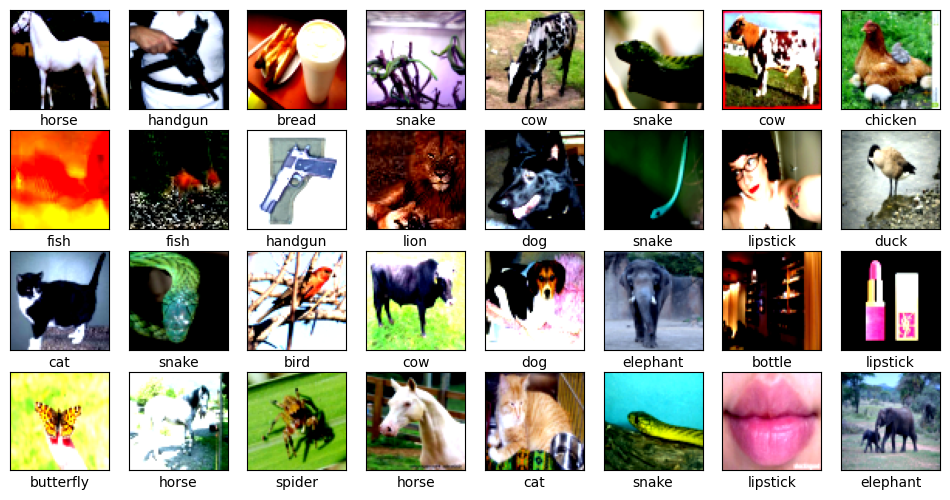

In [41]:
visualize_data(images, labels)

**For questions 3.1 to 3.7, you'll need to write your own model in a way that makes it easy for you to experiment with different architectures and parameters. The goal is to be able to pass the parameters to initialize a new instance of `YourModel` to build different network architectures with different parameters. Below are descriptions of some parameters for `YourModel`:**

1. `Block confirguration`: Our network consists of many blocks. Each block has the pattern `[conv, batch norm, activation, conv, batch norm, activation, max pool, dropout]`. All convolutional layers have filter size $(3, 3)$, strides $(1, 1)$ and padding = 1, and all max pool layers have strides $(2, 2)$, kernel size $2$, and padding = 0. The network will consists of a few blocks before applying a linear layer to output the logits for the softmax layer.

2. `list_feature_maps`: the number of feature maps in the blocks of the network. For example, if `list_feature_maps = [16, 32, 64]`, our network has three blocks with the input_channels or number of feature maps are `16, 32`, and `64` respectively.
3. `drop_rate`: the keep probability for dropout. Setting `drop_rate` to $0.0$ means not using dropout.
4. `batch_norm`: the batch normalization function is used or not. Setting `batch_norm` to `false` means not using batch normalization.
5. `use_skip`: the skip connection is used in the blocks or not. Setting this to `true` means that we use `1x1` Conv2D with `strides=2` for the skip connection.
6. At the end, you need to apply `global average pooling (GAP)` (`AdaptiveAvgPool2d((1, 1))`) to flatten the 3D output tensor before defining the output linear layer for predicting the labels.



Here is the model confirguration of `YourCNN` if the `list_feature_maps = [16, 32, 64]` and `batch_norm = true`.

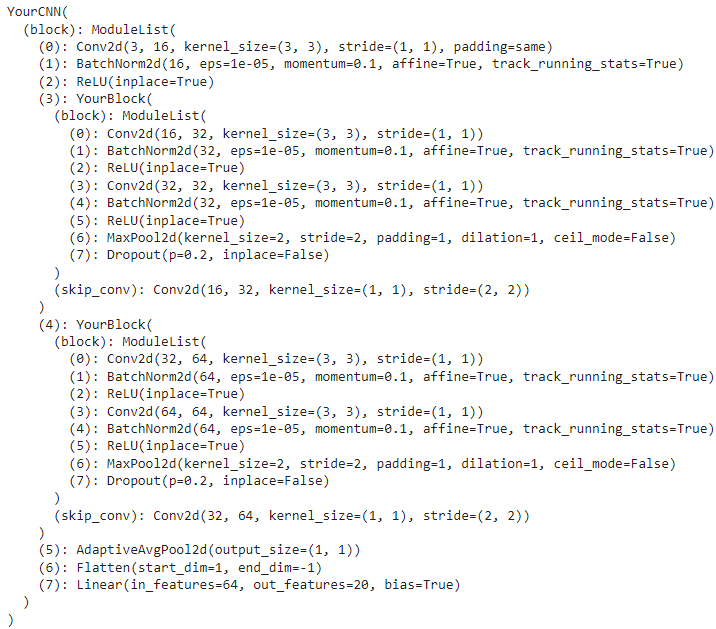

<span style="color:red">**Question 3.1:**</span> **You need to implement the aforementioned CNN**.

**First, you need to implement the block of our CNN in the class `YourBlock`. You can ignore `use_skip` and `skip connection` for simplicity. However, you cannot earn full marks for this question.**

<div style="text-align: right"> <span style="color:red">[6 points]</span> </div>

In [9]:
#Your code here
class YourBlock(nn.Module):
    def __init__(self, in_feature_maps, out_feature_maps, drop_rate = 0.2, batch_norm = True, use_skip = True):
        super(YourBlock, self).__init__()
        self.use_skip = use_skip
        self.block = nn.ModuleList()
        self.block.append(nn.Conv2d(in_feature_maps, out_feature_maps, kernel_size=3, padding=1))
        self.block.append(nn.BatchNorm2d(out_feature_maps) if batch_norm else nn.Identity())
        self.block.append(nn.ReLU(inplace=True))
        self.block.append(nn.Conv2d(out_feature_maps, out_feature_maps, kernel_size=3, padding=1))
        self.block.append(nn.BatchNorm2d(out_feature_maps) if batch_norm else nn.Identity())
        self.block.append(nn.ReLU(inplace=True))
        self.block.append(nn.MaxPool2d(kernel_size=2, stride=2, padding=1))
        self.block.append(nn.Dropout(drop_rate))
        self.skip_conv = nn.Conv2d(in_feature_maps, out_feature_maps, kernel_size=1, stride=2) if self.use_skip else nn.Identity()

    def forward(self, x):
        for layer in self.block:
            x = layer(x)
        return x

**Second, you need to use the above `YourBlock` to implement the class `YourCNN`**.

<div style="text-align: right"> <span style="color:red">[6 points]</span> </div>

In [10]:
class YourCNN(nn.Module):
    def __init__(self, list_feature_maps = [16, 32, 64], drop_rate = 0.2, batch_norm= True, use_skip = True):
        super(YourCNN, self).__init__()
        self.block = nn.ModuleList()
        self.block.append(nn.Conv2d(3, list_feature_maps[0], kernel_size=3, padding=1))
        self.block.append(nn.BatchNorm2d(list_feature_maps[0]) if batch_norm else nn.Identity())
        self.block.append(nn.ReLU(inplace=True))
        self.block.append(YourBlock(in_feature_maps=list_feature_maps[0],
                           out_feature_maps=list_feature_maps[1],
                           drop_rate=drop_rate,
                           batch_norm=batch_norm,
                           use_skip=use_skip))
        self.block.append(YourBlock(in_feature_maps=list_feature_maps[1],
                           out_feature_maps=list_feature_maps[2],
                           drop_rate=drop_rate,
                           batch_norm=batch_norm,
                           use_skip=use_skip))
        self.block.append(nn.AdaptiveAvgPool2d((1, 1)))
        self.block.append(nn.Flatten())
        self.block.append(nn.Linear(list_feature_maps[2], 20))

    def forward(self, x):
        for layer in self.block:
            x = layer(x)
        return x

**We declare `my_cnn` from `YourCNN` as follows**.

In [11]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
my_cnn = YourCNN(list_feature_maps = [16, 32, 64], use_skip = True)
my_cnn = my_cnn.to(device)
print(my_cnn)

YourCNN(
  (block): ModuleList(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): YourBlock(
      (block): ModuleList(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
        (7): Dropout(p=0.2, inplace=False)
      )
      (skip_conv): Conv2d(16, 32, kernel_size=(1, 1), stride=(2, 2))
    )
    (4): YourBlock(
      (block): ModuleList(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1)

**We declare the optimizer and the loss function.**

In [12]:
# Loss and optimizer
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(my_cnn.parameters(), lr=learning_rate)

**Here are the codes to compute the loss and accuracy.**

In [13]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

def compute_loss(model, loss_fn, loader):
    loss = 0
    # Set model to eval mode for inference
    model.eval()
    with torch.no_grad():  # No need to track gradients for validation
        for (batchX, batchY) in loader:
            # Move data to the same device as the model
            batchX, batchY = batchX.to(device).type(torch.float32), batchY.to(device).type(torch.long)
            loss += loss_fn(model(batchX), batchY)
    # Set model back to train mode
    model.train()
    return float(loss)/len(loader)

In [14]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

def compute_acc(model, loader):
    correct = 0
    totals = 0
    # Set model to eval mode for inference
    model.eval()
    for (batchX, batchY) in loader:
        # Move batchX and batchY to the same device as the model
        batchX, batchY = batchX.to(device).type(torch.float32), batchY.to(device)
        outputs = model(batchX)  # feed batch to the model
        totals += batchY.size(0)  # accumulate totals with the current batch size
        predicted = torch.argmax(outputs.data, 1)  # get the predicted class
        # Move batchY to the same device as predicted for comparison
        correct += (predicted == batchY).sum().item()
    return correct / totals

**Here is the code to train our model.**

In [15]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

def fit(model= None, train_loader = None, valid_loader= None, optimizer = None,
        num_epochs = 50, verbose = True, seed= 1234):
    torch.manual_seed(seed)
    # Move the model to the device before initializing the optimizer
    model.to(device) # Move the model to the GPU

    if optimizer == None:
        optim = torch.optim.Adam(model.parameters(), lr = 0.001) # Now initialize optimizer with model on GPU
    else:
        optim = optimizer
    history = dict()
    history['val_loss'] = list()
    history['val_acc'] = list()
    history['train_loss'] = list()
    history['train_acc'] = list()

    for epoch in range(num_epochs):
        model.train()
        for (X, y) in train_loader:
            # Move input data to the same device as the model
            X,y = X.to(device), y.to(device)
            # Forward pass
            outputs = model(X.type(torch.float32)) # X is already on the correct device
            loss = loss_fn(outputs, y.type(torch.long))
            # Backward and optimize
            optim.zero_grad()
            loss.backward()
            optim.step()
        #losses and accuracies for epoch
        val_loss = compute_loss(model, loss_fn, valid_loader)
        val_acc = compute_acc(model, valid_loader)
        train_loss = compute_loss(model, loss_fn, train_loader)
        train_acc = compute_acc(model, train_loader)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        if not verbose: #verbose = True means we do show the training information during training
            print(f"Epoch {epoch+1}/{num_epochs}")
            print(f"train loss= {train_loss:.4f} - train acc= {train_acc*100:.2f}% - valid loss= {val_loss:.4f} - valid acc= {val_acc*100:.2f}%")
    return history

In [16]:
history = fit(model= my_cnn, train_loader=train_loader, valid_loader = val_loader, optimizer = optimizer, num_epochs= 50, verbose = False)

Epoch 1/50
train loss= 2.3362 - train acc= 27.78% - valid loss= 2.3556 - valid acc= 26.29%
Epoch 2/50
train loss= 2.0442 - train acc= 35.91% - valid loss= 2.0926 - valid acc= 33.16%
Epoch 3/50
train loss= 1.9501 - train acc= 39.16% - valid loss= 2.0010 - valid acc= 39.70%
Epoch 4/50
train loss= 1.7464 - train acc= 46.82% - valid loss= 1.7987 - valid acc= 44.77%
Epoch 5/50
train loss= 1.6791 - train acc= 46.71% - valid loss= 1.7242 - valid acc= 45.72%
Epoch 6/50
train loss= 1.6672 - train acc= 47.04% - valid loss= 1.7008 - valid acc= 47.20%
Epoch 7/50
train loss= 1.5521 - train acc= 50.43% - valid loss= 1.6183 - valid acc= 50.58%
Epoch 8/50
train loss= 1.4757 - train acc= 55.10% - valid loss= 1.5427 - valid acc= 52.27%
Epoch 9/50
train loss= 1.4764 - train acc= 53.34% - valid loss= 1.5437 - valid acc= 51.32%
Epoch 10/50
train loss= 1.4639 - train acc= 53.41% - valid loss= 1.5442 - valid acc= 50.37%
Epoch 11/50
train loss= 1.4041 - train acc= 56.29% - valid loss= 1.4762 - valid acc= 54.7

<span style="color:red">**Question 3.2:**</span> **Now, let us tune the number of blocks $use\_skip \in \{true,false\}$ and $learning\_rate \in \{0.001, 0.0005\}$. Write your code for this tuning and report the result of the best model on the testing set. Note that you need to show your code for tuning and evaluating on the test set to earn the full marks. During tuning, you can set the instance variable `verbose` of your model to `True` for not showing the training details of each epoch.**

Note that for this question, depending on your computational resource, you can choose `list_feature_maps= [32, 64]` or `list_feature_maps= [16, 32, 64]`.

<div style="text-align: right"> <span style="color:red">[3 points]</span> </div>

In [17]:
import torch.optim as optim

#Your code here
use_skip_options = [True, False]
learning_rate_options = [0.001, 0.0005]
best_accuracy = 0.0
best_params = {}

for use_skip in use_skip_options:
    for learning_rate in learning_rate_options:
        print(f'Training with use_skip={use_skip} and learning_rate={learning_rate}')
        model = YourCNN(list_feature_maps=[16, 32, 64], drop_rate=0.2, batch_norm=True, use_skip=use_skip)
        model = model.to(device)
        loss_fn = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        history = fit(model=model, train_loader=train_loader, valid_loader=val_loader, optimizer=optimizer, num_epochs=50, verbose=True)
        accuracy = max(history['val_acc'])
        print(f'Test Accuracy: {accuracy*100:.2f}%\n')
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = {'use_skip': use_skip, 'learning_rate': learning_rate}

print(f'Best Accuracy: {best_accuracy*100:.2f}% with parameters: {best_params}')

Training with use_skip=True and learning_rate=0.001
Test Accuracy: 71.81%

Training with use_skip=True and learning_rate=0.0005
Test Accuracy: 69.06%

Training with use_skip=False and learning_rate=0.001
Test Accuracy: 71.70%

Training with use_skip=False and learning_rate=0.0005
Test Accuracy: 68.74%

Best Accuracy: 71.81% with parameters: {'use_skip': True, 'learning_rate': 0.001}


**Please note that you are struggling in implementing the aforementioned CNN. You can use the MiniVGG network in our labs for doing the following questions. However, you cannot earn any mark for 3.1 and 3.2.**

<span style="color:red">**Question 3.3:**</span> **Exploring Data Mixup Technique for Improving Generalization Ability.**
   
<div style="text-align: right"> <span style="color:red">[4 points]</span> </div>

Data mixup is another super-simple technique used to boost the generalization ability of deep learning models. You need to incoroporate data mixup technique to the above deep learning model and experiment its performance. There are some papers and documents for data mixup as follows:
- Main paper for data mixup [link for main paper](https://openreview.net/pdf?id=r1Ddp1-Rb) and a good article [article link](https://www.inference.vc/mixup-data-dependent-data-augmentation/).

You need to extend your model developed above, train a model using data mixup, and write your observations and comments about the result.

Data Mixup is a data augmentation technique used in training deep learning models. It generates new virtual training examples by combining pairs of existing examples and their corresponding labels through linear interpolation. The primary goal of Data Mixup is to improve the generalisation ability of the model, reduce overfitting, and increase robustness against adversarial attacks.

In traditional supervised learning, a model is trained using input samples `x` and their corresponding labels `y`. Data Mixup works by creating new training samples as follows:
1. Randomly select two samples $(x_i, y_i)$ and $(x_j, y_j)$ from the training set.
2. Generate a random mixing coefficient $\lambda$ between 0 and 1, typically drawn from a Beta distribution.
3. Create a new training sample by linearly interpolating between the two selected samples and their labels:
$$
\tilde{x} = \lambda x_i + (1 - \lambda) x_j
$$

In [22]:
use_skip = True
learning_rate = 0.001
model = YourCNN(list_feature_maps=[16, 32, 64], drop_rate=0.2, batch_norm=True, use_skip=use_skip)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [19]:
def mixup_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [20]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

def fit_mixup(model= None, train_loader = None, valid_loader= None, optimizer = None,
        num_epochs = 50, verbose = True, alpha=1.0, seed= 1234):
    torch.manual_seed(seed)
    # Move the model to the device before initializing the optimizer
    model.to(device) # Move the model to the GPU

    if optimizer == None:
        optim = torch.optim.Adam(model.parameters(), lr = 0.001) # Now initialize optimizer with model on GPU
    else:
        optim = optimizer
    history = dict()
    history['val_loss'] = list()
    history['val_acc'] = list()
    history['train_loss'] = list()
    history['train_acc'] = list()

    for epoch in range(num_epochs):
        model.train()
        for (inputs, targets) in train_loader:
            # Move input data to the same device as the model
            inputs, targets = inputs.to(device), targets.to(device)
            inputs, targets_a, targets_b, lam = mixup_data(inputs, targets, alpha=alpha)
            outputs = model(inputs)
            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
            # Forward pass
            outputs = model(inputs.type(torch.float32)) # X is already on the correct device
            loss = loss_fn(outputs, targets.type(torch.long))
            # Backward and optimize
            optim.zero_grad()
            loss.backward()
            optim.step()
        #losses and accuracies for epoch
        val_loss = compute_loss(model, loss_fn, valid_loader)
        val_acc = compute_acc(model, valid_loader)
        train_loss = compute_loss(model, loss_fn, train_loader)
        train_acc = compute_acc(model, train_loader)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        if not verbose: #verbose = True means we do show the training information during training
            print(f"Epoch {epoch+1}/{num_epochs}")
            print(f"train loss= {train_loss:.4f} - train acc= {train_acc*100:.2f}% - valid loss= {val_loss:.4f} - valid acc= {val_acc*100:.2f}%")
    return history

In [23]:
history = fit_mixup(model=model, train_loader=train_loader, valid_loader=val_loader, optimizer=optimizer, num_epochs=50, verbose=False, alpha=1.0)

Epoch 1/50
train loss= 2.6506 - train acc= 19.18% - valid loss= 2.6603 - valid acc= 18.90%
Epoch 2/50
train loss= 2.5253 - train acc= 24.73% - valid loss= 2.5223 - valid acc= 23.86%
Epoch 3/50
train loss= 2.4401 - train acc= 27.73% - valid loss= 2.4448 - valid acc= 25.87%
Epoch 4/50
train loss= 2.2961 - train acc= 31.74% - valid loss= 2.3325 - valid acc= 27.98%
Epoch 5/50
train loss= 2.3096 - train acc= 30.97% - valid loss= 2.3151 - valid acc= 28.41%
Epoch 6/50
train loss= 2.2288 - train acc= 37.67% - valid loss= 2.2506 - valid acc= 36.22%
Epoch 7/50
train loss= 2.1574 - train acc= 36.74% - valid loss= 2.1904 - valid acc= 35.48%
Epoch 8/50
train loss= 2.1322 - train acc= 38.04% - valid loss= 2.1601 - valid acc= 36.33%
Epoch 9/50
train loss= 2.1043 - train acc= 40.16% - valid loss= 2.1193 - valid acc= 40.76%
Epoch 10/50
train loss= 2.0540 - train acc= 40.86% - valid loss= 2.0956 - valid acc= 39.28%
Epoch 11/50
train loss= 2.1387 - train acc= 39.14% - valid loss= 2.1750 - valid acc= 37.0

The use of data mixup has resulted in both training and validation accuracy being lower than before. This is a common outcome when using mixup, as it blends different data points, which can make the training process more challenging initially. Mixup can lead to slower convergence and lower early accuracy because it regularizes the model, forcing it to learn smoother decision boundaries. While this may decrease accuracy in the short term, mixup typically improves the generalization and robustness to overfitting in the long run. Therefore, continued training or hyperparameter tuning may help realize the full benefits of mixup.

<span style="color:red">**Question 3.4:**</span> **Exploring CutMix Technique for Improving Generalization Ability.**
   
<div style="text-align: right"> <span style="color:red">[4 points]</span> </div>

Data mixup is another super-simple technique used to boost the generalization ability of deep learning models. You need to incoroporate data mixup technique to the above deep learning model and experiment its performance. There are some papers and documents for data mixup as follows:
- Main paper for Cutmix [link for main paper](https://arxiv.org/pdf/1905.04899v2) and a good article [article link](https://shorturl.at/TNwjv).

You need to extend your model developed above, train a model using data mixup, and write your observations and comments about the result.

CutMix involves cutting a rectangular patch from one image and pasting it onto another image. This process creates a new, mixed image that contains parts from two different images. The labels of the two images are also mixed according to the area of the patch.

In [24]:
use_skip = True
learning_rate = 0.001
model = YourCNN(list_feature_maps=[16, 32, 64], drop_rate=0.2, batch_norm=True, use_skip=use_skip)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [25]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bbx2, bby1, bby2

def cutmix_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)

    bbx1, bbx2, bby1, bby2 = rand_bbox(x.size(), lam)
    x[:, :, bbx1:bbx2, bby1:bby2] = x[index, :, bbx1:bbx2, bby1:bby2]

    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.size()[-1] * x.size()[-2]))
    
    y_a, y_b = y, y[index]
    return x, y_a, y_b, lam

def cutmix_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [26]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

def fit_cutmix(model= None, train_loader = None, valid_loader= None, optimizer = None,
        num_epochs = 50, verbose = True, alpha=1.0, seed= 1234):
    torch.manual_seed(seed)
    # Move the model to the device before initializing the optimizer
    model.to(device) # Move the model to the GPU

    if optimizer == None:
        optim = torch.optim.Adam(model.parameters(), lr = 0.001) # Now initialize optimizer with model on GPU
    else:
        optim = optimizer
    history = dict()
    history['val_loss'] = list()
    history['val_acc'] = list()
    history['train_loss'] = list()
    history['train_acc'] = list()

    for epoch in range(num_epochs):
        model.train()
        for (inputs, targets) in train_loader:
            # Move input data to the same device as the model
            inputs, targets = inputs.to(device), targets.to(device)
            inputs, targets_a, targets_b, lam = cutmix_data(inputs, targets, alpha=alpha)
            outputs = model(inputs)
            loss = cutmix_criterion(criterion, outputs, targets_a, targets_b, lam)
            # Forward pass
            outputs = model(inputs.type(torch.float32)) # X is already on the correct device
            loss = loss_fn(outputs, targets.type(torch.long))
            # Backward and optimize
            optim.zero_grad()
            loss.backward()
            optim.step()
        #losses and accuracies for epoch
        val_loss = compute_loss(model, loss_fn, valid_loader)
        val_acc = compute_acc(model, valid_loader)
        train_loss = compute_loss(model, loss_fn, train_loader)
        train_acc = compute_acc(model, train_loader)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        if not verbose: #verbose = True means we do show the training information during training
            print(f"Epoch {epoch+1}/{num_epochs}")
            print(f"train loss= {train_loss:.4f} - train acc= {train_acc*100:.2f}% - valid loss= {val_loss:.4f} - valid acc= {val_acc*100:.2f}%")
    return history

In [27]:
history = fit_cutmix(model=model, train_loader=train_loader, valid_loader=val_loader, optimizer=optimizer, num_epochs=50, verbose=False, alpha=1.0)

Epoch 1/50
train loss= 2.4326 - train acc= 25.74% - valid loss= 2.4410 - valid acc= 25.55%
Epoch 2/50
train loss= 2.2028 - train acc= 32.06% - valid loss= 2.2530 - valid acc= 31.26%
Epoch 3/50
train loss= 2.0765 - train acc= 35.29% - valid loss= 2.1016 - valid acc= 32.10%
Epoch 4/50
train loss= 1.8988 - train acc= 42.22% - valid loss= 1.9397 - valid acc= 40.44%
Epoch 5/50
train loss= 1.9047 - train acc= 40.24% - valid loss= 1.9395 - valid acc= 39.92%
Epoch 6/50
train loss= 1.8847 - train acc= 41.51% - valid loss= 1.9154 - valid acc= 40.87%
Epoch 7/50
train loss= 1.8009 - train acc= 43.37% - valid loss= 1.8744 - valid acc= 41.08%
Epoch 8/50
train loss= 1.7096 - train acc= 45.40% - valid loss= 1.7551 - valid acc= 41.82%
Epoch 9/50
train loss= 1.7192 - train acc= 46.54% - valid loss= 1.7280 - valid acc= 47.31%
Epoch 10/50
train loss= 1.6252 - train acc= 48.37% - valid loss= 1.6712 - valid acc= 44.35%
Epoch 11/50
train loss= 1.6240 - train acc= 49.57% - valid loss= 1.6490 - valid acc= 48.1

After applying CutMix, both the training and validation accuracy decreased compared to the original results. This is expected since CutMix, like other augmentation techniques, introduces more complex and challenging training data by mixing images and labels. As a result, the model may initially struggle to fit the altered data, leading to lower early accuracy. However, CutMix is known to improve model robustness and generalization in the long term, especially against overfitting. It may be beneficial to continue training and adjust the learning rate or CutMix hyperparameters to fully leverage its advantages.

<span style="color:red">**Question 3.5:**</span> Implement the **one-versus-all (OVA)** loss. The details are as follows:
- You need to apply `the sigmoid activation function` to logits $h = [h_1, h_2,...,h_M]$ instead of `the softmax activation` function as usual to obtain $p = [p_1, p_2,...,p_M]$, meaning that $p_i = sigmoid(h_i), i=1,...,M$. Note that $M$ is the number of classes.
- Given a data example $x$ with the ground-truth label $y$, the idea is to maximize the likelihood $p_y$ and to minimize the likelihoods $p_i, i \neq y$. Therefore, the objective function is to find the model parameters to
  - $\max\left\{ \log p_{y}+\sum_{i\neq y}\log(1-p_{i})\right\}$ or equivalently $\min\left\{ -\log p_{y}-\sum_{i\neq y}\log(1-p_{i})\right\}$.
  - For example, if $M=3$ and $y=2$, you need to minimize $\min\left\{ -\log(1-p_{1})-\log p_{2}-\log(1-p_{3})\right\}$.

Compare the model trained with the OVA loss and the same model trained with the standard cross-entropy loss.

<div style="text-align: right"> <span style="color:red">[4 points]</span> </div>



In [36]:
use_skip = True
learning_rate = 0.001
model = YourCNN(list_feature_maps=[16, 32, 64], drop_rate=0.2, batch_norm=True, use_skip=use_skip)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [37]:
import torch.nn.functional as F

def ova_loss(logits, labels):
    num_classes = logits.size(1)
    probs = torch.sigmoid(logits)
    probs = torch.clamp(probs, min=1e-7, max=1.0 - 1e-7)
    one_hot_labels = F.one_hot(labels, num_classes).float()
    pos_loss = -torch.log(probs) * one_hot_labels
    neg_loss = -torch.log(1.0 - probs) * (1.0 - one_hot_labels)
    total_loss = pos_loss + neg_loss
    return total_loss.sum(dim=1).mean()

In [38]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

def fit_ovaloss(model= None, train_loader = None, valid_loader= None, optimizer = None,
        num_epochs = 50, verbose = True, seed= 1234):
    torch.manual_seed(seed)
    # Move the model to the device before initializing the optimizer
    model.to(device) # Move the model to the GPU

    if optimizer == None:
        optim = torch.optim.Adam(model.parameters(), lr = 0.001) # Now initialize optimizer with model on GPU
    else:
        optim = optimizer
    history = dict()
    history['val_loss'] = list()
    history['val_acc'] = list()
    history['train_loss'] = list()
    history['train_acc'] = list()

    for epoch in range(num_epochs):
        model.train()
        for (X, y) in train_loader:
            # Move input data to the same device as the model
            X,y = X.to(device), y.to(device)
            # Forward pass
            outputs = model(X.type(torch.float32)) # X is already on the correct device
            loss = ova_loss(outputs, y.type(torch.long))
            # Backward and optimize
            optim.zero_grad()
            loss.backward()
            optim.step()
        #losses and accuracies for epoch
        val_loss = compute_loss(model, loss_fn, valid_loader)
        val_acc = compute_acc(model, valid_loader)
        train_loss = compute_loss(model, loss_fn, train_loader)
        train_acc = compute_acc(model, train_loader)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        if not verbose: #verbose = True means we do show the training information during training
            print(f"Epoch {epoch+1}/{num_epochs}")
            print(f"train loss= {train_loss:.4f} - train acc= {train_acc*100:.2f}% - valid loss= {val_loss:.4f} - valid acc= {val_acc*100:.2f}%")
    return history

In [39]:
history = fit_ovaloss(model=model, train_loader=train_loader, valid_loader=val_loader, optimizer=optimizer, num_epochs=50, verbose=False)

Epoch 1/50
train loss= 2.4792 - train acc= 23.88% - valid loss= 2.4933 - valid acc= 23.97%
Epoch 2/50
train loss= 2.2195 - train acc= 31.31% - valid loss= 2.2641 - valid acc= 29.25%
Epoch 3/50
train loss= 2.0400 - train acc= 36.85% - valid loss= 2.0651 - valid acc= 36.64%
Epoch 4/50
train loss= 1.8576 - train acc= 41.93% - valid loss= 1.9152 - valid acc= 39.18%
Epoch 5/50
train loss= 1.7436 - train acc= 45.39% - valid loss= 1.7742 - valid acc= 44.24%
Epoch 6/50
train loss= 1.7674 - train acc= 45.71% - valid loss= 1.7997 - valid acc= 43.29%
Epoch 7/50
train loss= 1.6574 - train acc= 48.54% - valid loss= 1.7412 - valid acc= 46.04%
Epoch 8/50
train loss= 1.5378 - train acc= 52.25% - valid loss= 1.5490 - valid acc= 49.95%
Epoch 9/50
train loss= 1.5469 - train acc= 50.67% - valid loss= 1.6192 - valid acc= 48.68%
Epoch 10/50
train loss= 1.4441 - train acc= 54.07% - valid loss= 1.5009 - valid acc= 51.32%
Epoch 11/50
train loss= 1.4248 - train acc= 55.62% - valid loss= 1.5032 - valid acc= 52.1

After using the one-versus-all (OVA) loss, both the training and validation accuracy improved compared to the original results. This indicates that the OVA loss function is more effective in separating classes for this particular task, allowing the model to learn clearer decision boundaries. The improved accuracy suggests that the model benefits from treating each class independently, which can be especially useful in imbalanced or multi-class classification problems. The increased validation accuracy also suggests better generalization, making OVA loss a promising choice for further optimization.

<span style="color:red">**Question 3.6:**</span> **Attack your best obtained model with PGD attacks with $\epsilon= 0.0313, k=20, \eta= 0.002$ on the testing set. Write the code for the attacks and report the robust accuracies. Also choose a random set of 20 clean images in the testing set and visualize the original and attacked images.**
   
<div style="text-align: right"> <span style="color:red">[4 points]</span> </div>

Projected Gradient Descent (PGD) Attack is one of the most popular and effective methods for generating adversarial examples. These attacks are designed to test the robustness of machine learning models, particularly deep neural networks, by adding small, carefully crafted perturbations to the input data that can fool the model into making incorrect predictions.

Key Concepts of PGD Attack:
1. Adversarial Examples: These are inputs to a machine learning model that have been intentionally modified in a way that causes the model to make a mistake. The modifications are often small and imperceptible to humans but can significantly impact the model’s output.
2.	Gradient-Based Attacks: PGD is a gradient-based attack, meaning it uses the gradient of the loss function with respect to the input data to determine how to modify the input to increase the loss (i.e., to fool the model).
3.	Iterative Process: Unlike simpler attacks like the Fast Gradient Sign Method (FGSM), which applies a single perturbation, PGD applies the perturbation iteratively over several steps. At each step, the input is modified slightly in the direction that maximizes the loss.
4.	Projection Step: After each perturbation step, PGD includes a projection step that ensures the perturbed input remains within a specified “epsilon-ball” around the original input. This means the perturbation stays within a certain magnitude, controlled by a parameter $\epsilon$ , which limits how much the input can be altered.

In [59]:
# PGD attack function
def pgd_attack(model, images, labels, eps, alpha, num_iter):
    images = images.clone().detach().to(device)
    labels = labels.to(device)
    loss = nn.CrossEntropyLoss()

    adv_images = images.clone().detach()

    for i in range(num_iter):
        adv_images.requires_grad = True
        outputs = model(adv_images)

        model.zero_grad()
        cost = loss(outputs, labels).to(device)
        cost.backward()

        adv_images = adv_images + alpha * adv_images.grad.sign()
        perturbation = torch.clamp(adv_images - images, min=-eps, max=eps)
        adv_images = torch.clamp(images + perturbation, min=0, max=1).detach()

        # Re-enable gradient computation for the next iteration
        adv_images.requires_grad = True

    return adv_images

# Visualizing images (both original and attacked)
def visualize_images(original_images, attacked_images, labels):
    class_names = ['bird', 'bottle', 'bread', 'butterfly', 'cake', 'cat', 'chicken', 'cow', 'dog', 'duck',
                  'elephant', 'fish', 'handgun', 'horse', 'lion', 'lipstick', 'seal', 'snake', 'spider', 'vase']
    original_images = original_images.cpu().numpy()
    attacked_images = attacked_images.cpu().numpy()
    
    fig, axes = plt.subplots(2, 10, figsize=(15, 4))
    for i in range(10):
        # Original images
        original_images[i] = np.clip(original_images[i], 0, 1)
        axes[0, i].imshow(np.transpose(original_images[i], (1, 2, 0)))
        axes[0, i].set_title(f"{class_names[labels[i].item()]}")
        axes[0, i].axis('off')
        # Attacked images
        attacked_images[i] = np.clip(attacked_images[i], 0, 1)
        axes[1, i].imshow(np.transpose(attacked_images[i], (1, 2, 0)))
        axes[1, i].set_title(f"{class_names[labels[i].item()]}")
        axes[1, i].axis('off')
    plt.show()

Robust Accuracy after PGD attack: 3.12%


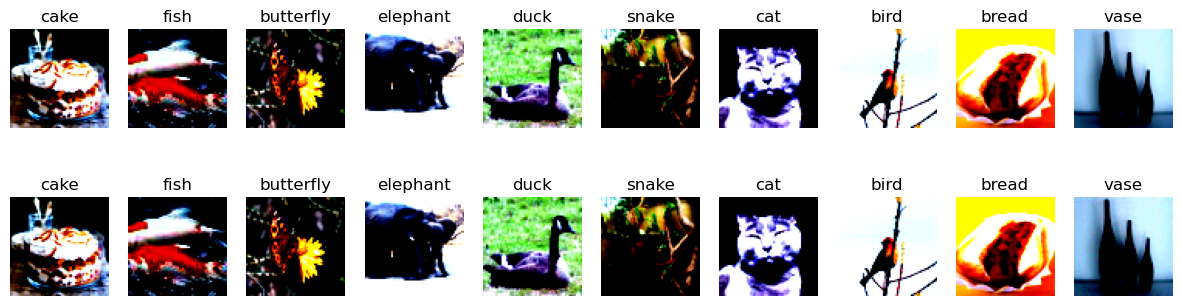

In [48]:
model.eval()

# Parameters for PGD attack
epsilon = 0.0313
alpha = 0.002
num_iter = 20

# Select a random batch of test images
dataiter = iter(val_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# Apply PGD attack
adv_images = pgd_attack(model, images, labels, epsilon, alpha, num_iter)

# Evaluate the robust accuracy after the attack
outputs = model(adv_images)
_, predicted = torch.max(outputs, 1)
robust_accuracy = (predicted == labels).sum().item() / labels.size(0)
print(f'Robust Accuracy after PGD attack: {robust_accuracy * 100:.2f}%')

# Visualize clean and attacked images
visualize_images(images.cpu(), adv_images.cpu(), labels.cpu())

<span style="color:red">**Question 3.7:**</span> **Train a robust model using adversarial training with PGD ${\epsilon= 0.0313, k=10, \eta= 0.002}$. Write the code for the adversarial training and report the robust accuracies. After finishing the training, you need to store your best robust model in the folder `./models` and load the model to evaluate the robust accuracies for PGD and FGSM attacks with $\epsilon= 0.0313, k=20, \eta= 0.002$ on the testing set.**
   
<div style="text-align: right"> <span style="color:red">[4 points]</span> </div>

In [62]:
# FGSM attack function
def fgsm_attack(model, images, labels, eps):
    images = images.clone().detach().to(device)
    labels = labels.to(device)
    loss = nn.CrossEntropyLoss()

    images.requires_grad = True
    outputs = model(images)

    model.zero_grad()
    cost = loss(outputs, labels).to(device)
    cost.backward()

    attack_images = images + eps * images.grad.sign()
    attack_images = torch.clamp(attack_images, min=0, max=1).detach()

    # Re-enable gradient computation for the next iteration
    attack_images.requires_grad = True

    return attack_images

# Evaluate robust accuracy after adversarial attacks
def evaluate_robust_accuracy(model, test_loader, attack_type, epsilon, alpha=None, k=None):
    model.eval()
    correct = 0
    total = 0

    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Apply PGD or FGSM attack
        if attack_type == 'PGD':
            adv_images = pgd_attack(model, images, labels, epsilon, alpha, k)
        elif attack_type == 'FGSM':
            adv_images = fgsm_attack(model, images, labels, epsilon)

        outputs = model(adv_images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# Save the model
def save_model(model, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save(model.state_dict(), path)

# Adversarial training
def adversarial_training(model, train_loader, val_loader, optimizer, num_epochs, epsilon, alpha, k, save_path):
    best_val_accuracy = 0.0
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            # Generate adversarial examples using PGD
            adv_images = pgd_attack(model, images, labels, epsilon, alpha, k)

            # Forward pass on clean images
            optimizer.zero_grad()
            outputs_clean = model(images)
            loss_clean = criterion(outputs_clean, labels)

            # Forward pass on adversarial examples
            outputs_adv = model(adv_images)
            loss_adv = criterion(outputs_adv, labels)

            # Combine the losses (50% each)
            loss = (loss_clean + loss_adv) / 2

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Statistics
            total_loss += loss.item()
            _, predicted = torch.max(outputs_adv.data, 1)  # Use adversarial output for accuracy tracking
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%')

        # Validate the model after each epoch
        val_accuracy = evaluate_robust_accuracy(model, val_loader, 'PGD', epsilon, alpha, k)
        print(f'Validation Accuracy: {val_accuracy:.2f}%')

        # Save the model if the validation accuracy improves
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            print(f'Best model found at epoch {epoch+1}, saving model with val accuracy {best_val_accuracy:.2f}%')
            save_model(model, save_path)

    print('Finished Adversarial Training')

In [63]:
use_skip = True
learning_rate = 0.001
model = YourCNN(list_feature_maps=[16, 32, 64], drop_rate=0.2, batch_norm=True, use_skip=use_skip)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Parameters for PGD attack and adversarial training
epsilon = 0.0313
alpha = 0.002
k = 10  # number of iterations for PGD during training
num_epochs = 50
save_path = './models/best_model.pth'

# Train the robust model with validation-based checkpointing
adversarial_training(model, train_loader, val_loader, optimizer, num_epochs, epsilon, alpha, k, save_path)

Epoch [1/50], Loss: 2.6506, Train Accuracy: 17.40%
Validation Accuracy: 11.19%
Best model found at epoch 1, saving model with val accuracy 11.19%
Epoch [2/50], Loss: 2.4122, Train Accuracy: 23.15%
Validation Accuracy: 17.63%
Best model found at epoch 2, saving model with val accuracy 17.63%
Epoch [3/50], Loss: 2.2859, Train Accuracy: 24.51%
Validation Accuracy: 19.11%
Best model found at epoch 3, saving model with val accuracy 19.11%
Epoch [4/50], Loss: 2.1906, Train Accuracy: 26.93%
Validation Accuracy: 24.39%
Best model found at epoch 4, saving model with val accuracy 24.39%
Epoch [5/50], Loss: 2.1183, Train Accuracy: 28.16%
Validation Accuracy: 19.96%
Epoch [6/50], Loss: 2.0562, Train Accuracy: 29.42%
Validation Accuracy: 18.06%
Epoch [7/50], Loss: 2.0035, Train Accuracy: 30.97%
Validation Accuracy: 16.16%
Epoch [8/50], Loss: 1.9744, Train Accuracy: 31.22%
Validation Accuracy: 24.39%
Epoch [9/50], Loss: 1.9257, Train Accuracy: 32.52%
Validation Accuracy: 24.18%
Epoch [10/50], Loss: 

In [67]:
# Load the best robust model
model.load_state_dict(torch.load(save_path))

# Evaluate robust accuracy on the test set for PGD and FGSM attacks
pgd_acc = evaluate_robust_accuracy(model, val_loader, attack_type='PGD', epsilon=0.0313, alpha=0.002, k=20)
fgsm_acc = evaluate_robust_accuracy(model, val_loader, attack_type='FGSM', epsilon=0.0313)

print(f'Robust Accuracy after PGD attack: {pgd_acc:.2f}%')
print(f'Robust Accuracy after FGSM attack: {fgsm_acc:.2f}%')

/var/folders/zf/40cm5cc50tz1d69ltk_gv8700000gn/T/ipykernel_2010/235512160.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


Robust Accuracy after PGD attack: 30.41%
Robust Accuracy after FGSM attack: 39.60%


<span style="color:red">**Question 3.8 (Kaggle competition)**</span>
<div style="text-align: right"> <span style="color:red">[10 points]</span> </div10

You can reuse the best model obtained in this assignment or develop new models to evaluate on the **testing set of the FIT3181/5215 Kaggle competion**. However, to gain any points for this question, your testing accuracy must **exceed** the accuracy threshold from a base model developed by us as shown in the leader board of the competition.

The marks for this question are as follows:
- If you are in *top 10%* of your cohort, you gain *10 points*.
- If you are in *top 20%* of your cohort, you gain *8 points*.
- If you are in *top 30%* of your cohort, you gain *6 points*.
- If you *beat* our base model, you gain *4 points*.

---
**<div style="text-align: center"> <span style="color:black">END OF ASSIGNMENT</span> </div>**
**<div style="text-align: center"> <span style="color:black">GOOD LUCK WITH YOUR ASSIGNMENT 1!</span> </div>**